<h1>Multimodal Large Language Models</h1>

This notebook is for based on [Hands-On Large Language Models](https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961) book by [Jay Alammar](https://www.linkedin.com/in/jalammar) and [Maarten Grootendorst](https://www.linkedin.com/in/mgrootendorst/).


In [ ]:
# # %%capture
# !pip install matplotlib transformers datasets accelerate sentence-transformers
# !pip install ipywidgets

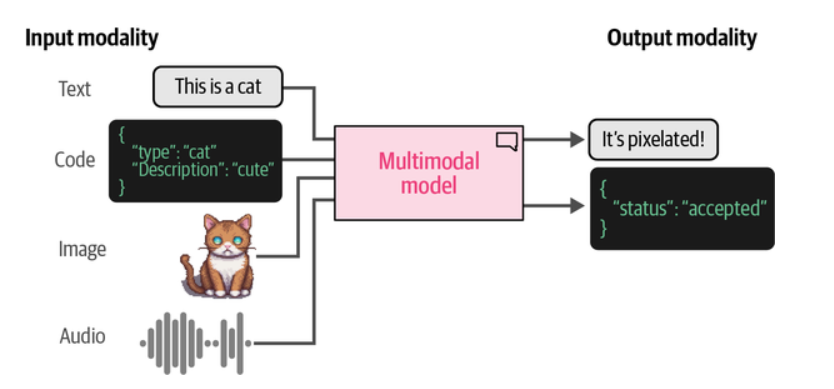

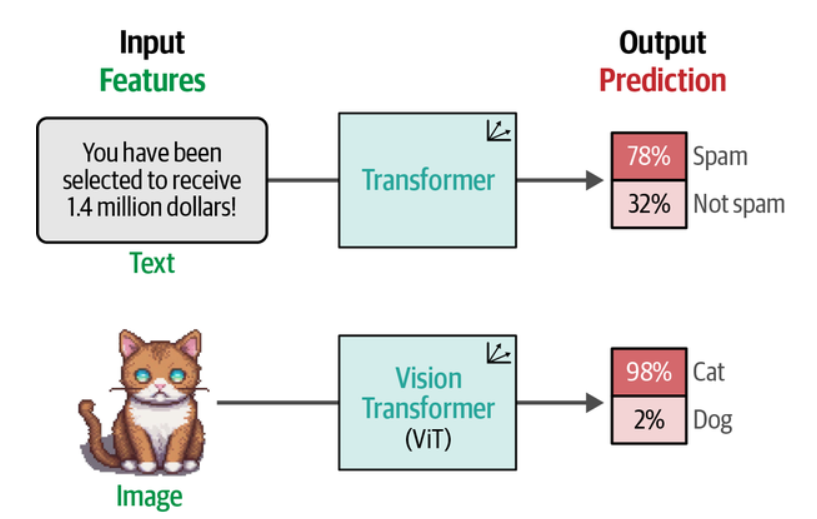

## CLIP

`Contrastive Language-Image Pre-training (CLIP)` is an embedding model that can compute embeddings of both images and texts.
The resulting embeddings lie in the same vector space.

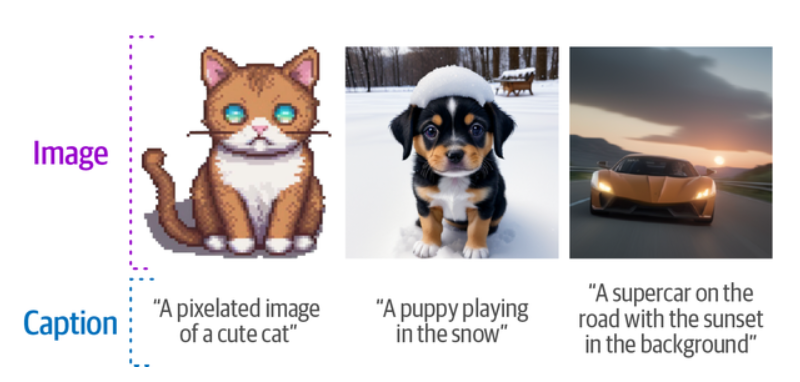

In [60]:
from urllib.request import urlopen
from PIL import Image

image = Image.open("images/puppy.png").convert("RGB")

caption = "a puppy playing in the snow"

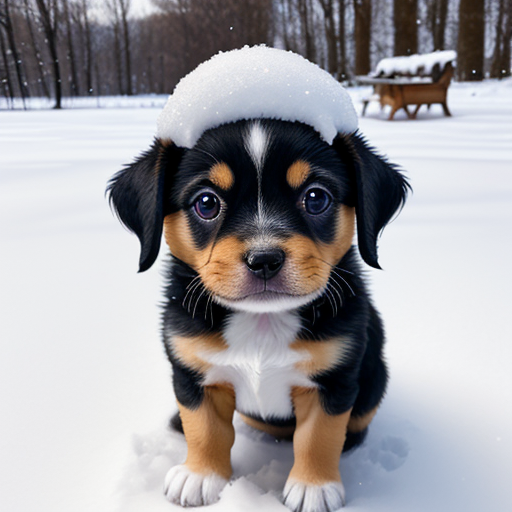

In [3]:
image

In [4]:
print(caption)

a puppy playing in the snow


### Embeddings

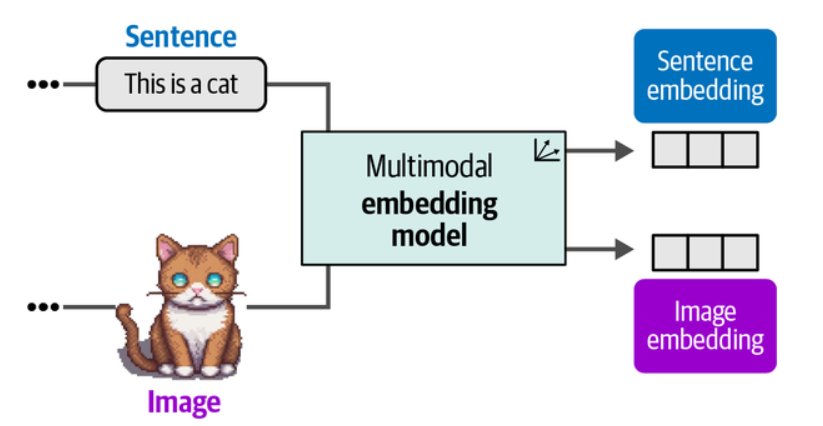

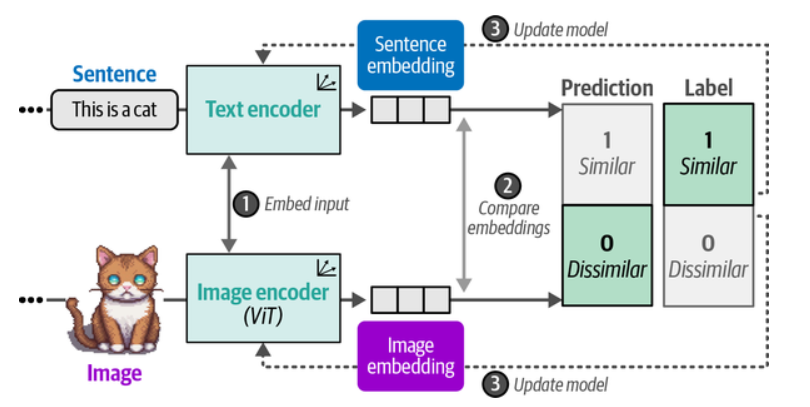

In [6]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel

model_id = "openai/clip-vit-base-patch32"

# Load a tokenizer to preprocess the text (to tokenize the text)
clip_tokenizer = CLIPTokenizerFast.from_pretrained(model_id)

# Load a processor to preprocess the images (to preprocess the image)
clip_processor = CLIPProcessor.from_pretrained(model_id)

# Main model for generating text and image embeddings
model = CLIPModel.from_pretrained(model_id)

In [61]:
caption

'a puppy playing in the snow'

In [8]:
# Tokenize our input (Preprocessing the text)
inputs = clip_tokenizer(caption, return_tensors="pt")
inputs

{'input_ids': tensor([[49406,   320,  6829,  1629,   530,   518,  2583, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [9]:
# Convert our input back to tokens
clip_tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

['<|startoftext|>',
 'a</w>',
 'puppy</w>',
 'playing</w>',
 'in</w>',
 'the</w>',
 'snow</w>',
 '<|endoftext|>']

In [10]:
# Create a text embedding
text_embedding = model.get_text_features(**inputs)
text_embedding.shape

torch.Size([1, 512])

In [12]:
# Load the image
image = Image.open("images/puppy.png").convert("RGB")

# Preprocess image (Preprocessing the image)
# It will preprocess the image according to the as the model's expected input, like its size and shape
processed_image = clip_processor(
                                    text=None, images=image, return_tensors='pt'
                                )['pixel_values']

processed_image.shape

torch.Size([1, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].


(-0.5, 223.5, 223.5, -0.5)

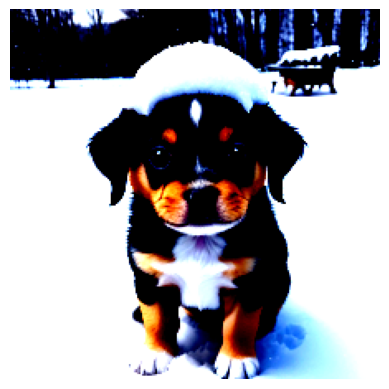

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Prepare image for visualization
img = processed_image.squeeze(0)
img = img.permute(*torch.arange(img.ndim - 1, -1, -1)).  # This is necessary because image data is represented in the shape (height, width, channels) for visualization, but the models often use (channels, height, width)
img = np.einsum('ijk->jik', img)

# Visualize preprocessed image
plt.imshow(img)
plt.axis('off')

In [17]:
# Create the image embedding
image_embedding = model.get_image_features(processed_image)
image_embedding.shape

torch.Size([1, 512])

In [18]:
# Normalize the embeddings
text_embedding /= text_embedding.norm(dim=-1, keepdim=True)
image_embedding /= image_embedding.norm(dim=-1, keepdim=True)

# Calculate their similarity
text_embedding = text_embedding.detach().cpu().numpy()
image_embedding = image_embedding.detach().cpu().numpy()
score = text_embedding @ image_embedding.T
score

array([[0.3314963]], dtype=float32)

### More Images

In [26]:
from urllib.request import urlopen
from PIL import Image

# Load an AI-generated image of a puppy playing in the snow
cat_path = "images/cat.png"
car_path = "images/car.png"
puppy_path = "images/puppy.png"
paths = [puppy_path, cat_path, car_path]
images = [Image.open(path).convert("RGBA") for path in paths]
captions = [
    "a puppy playing in the snow",
    "a pixelated image of a cute cat",
    "A supercar on the road \nwith the sunset in the background"
]

import numpy as np

# Embed all images
image_embeddings = []
for image in images:
  image_processed = clip_processor(images=image, return_tensors='pt')['pixel_values']
  image_embedding = model.get_image_features(image_processed).detach().cpu().numpy()[0]
  image_embeddings.append(image_embedding)
image_embeddings = np.array(image_embeddings)

# Embed all captions
text_embeddings = []
for caption in captions:
  inputs = clip_tokenizer(caption, return_tensors="pt")
  text_emb = model.get_text_features(**inputs).detach().cpu().numpy()[0]
  text_embeddings.append(text_emb)
text_embeddings = np.array(text_embeddings)

In [28]:
# Calculate cosine similarity between images and captions
from sklearn.metrics.pairwise import cosine_similarity
sim_matrix = cosine_similarity(image_embeddings, text_embeddings)

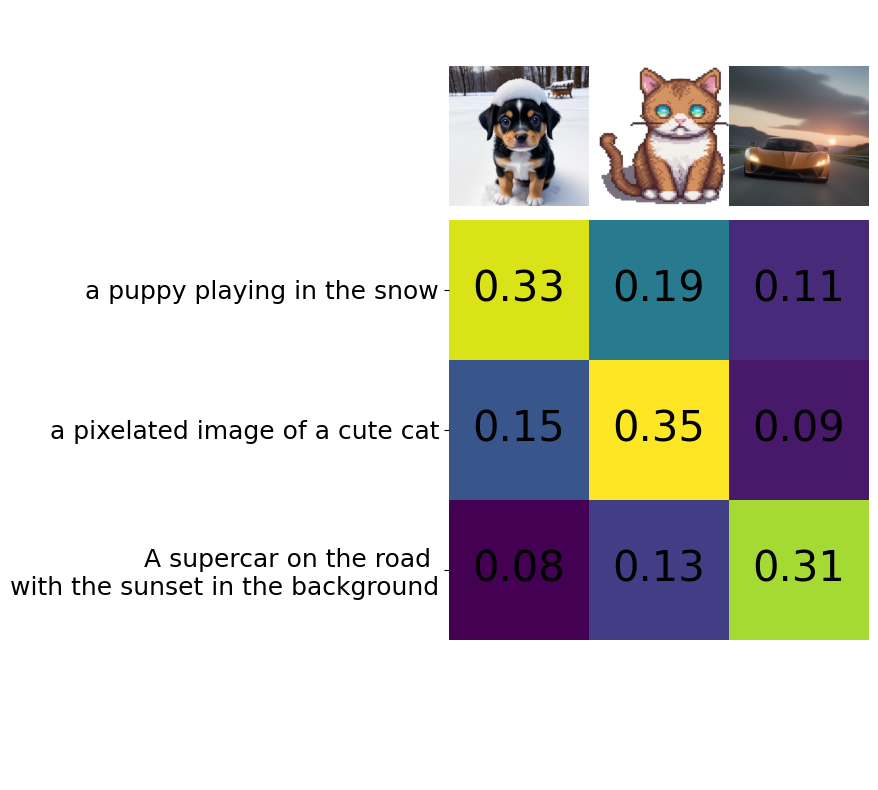

In [35]:
# Create base figure
plt.figure(figsize=(10,10))
plt.imshow(sim_matrix, cmap='viridis')

# Adjust ticks with correct labels
plt.yticks(range(len(captions)), captions, fontsize=18)
plt.xticks([])

# Visualize
for i, image in enumerate(images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")

# Add the captions at the correct indices
for x in range(sim_matrix.shape[1]):
    for y in range(sim_matrix.shape[0]):
        plt.text(x, y, f"{sim_matrix[y, x]:.2f}", ha="center", va="center", size=30)

# Remove unnecessary spines
for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

# Resize blocks
plt.xlim([-0.5, len(captions) - 0.5])
plt.ylim([len(captions) + 0.5, -2])
# plt.title("Similarity Matrix", size=10)
plt.savefig("sim_matrix.png", dpi=300, bbox_inches='tight')

### SBERT

`sentence-transformers` implements a few CLIP-based models that make it much
easier to create embeddings. It only takes a few lines of code:

In [36]:
from sentence_transformers import SentenceTransformer, util

# Load SBERT-compatible CLIP model
model = SentenceTransformer('clip-ViT-B-32')

# Encode the images
image_embeddings = model.encode(images)

# Encode the captions
text_embeddings = model.encode(captions)

#Compute cosine similarities
sim_matrix = util.cos_sim(image_embeddings, text_embeddings)
print(sim_matrix)

tensor([[0.3315, 0.1863, 0.1084],
        [0.1488, 0.3463, 0.0947],
        [0.0762, 0.1260, 0.3098]])


## BLIP-2

`Bootstrapping Language-Image Pre-training for Unified Vision-Language Understanding and Generation 2` - Bridging the Modality Gap

Creating a multimodal language model from scratch requires significant computing power and data. We would have to use billions of images, text, and image-text pairs to create such a model. As you can imagine, this is not easily feasible!

Instead of building the architecture from scratch, BLIP-2 bridges the vision-language gap by building a bridge, named the Querying Transformer (Q-Former), that connects a pretrained image encoder and a pretrained LLM.

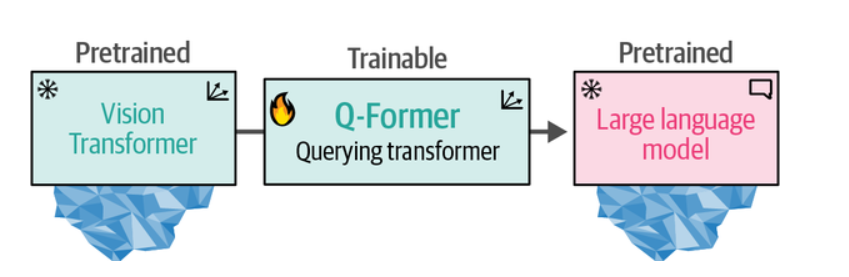

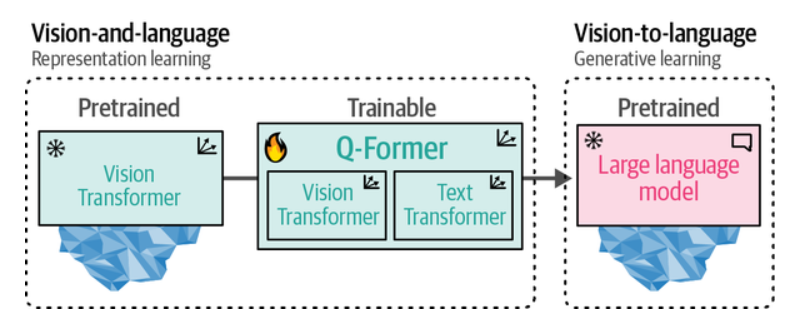

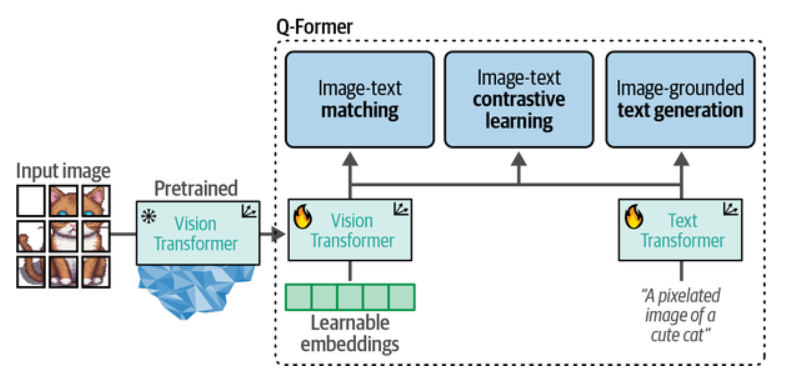

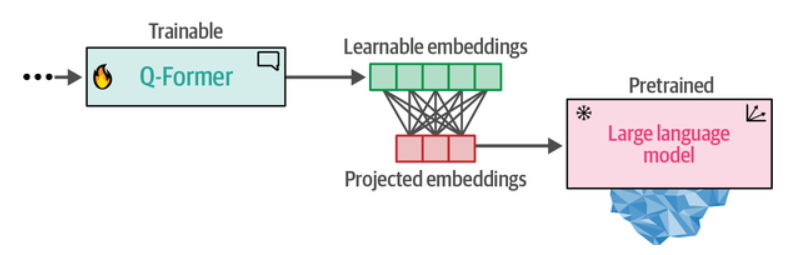

In [37]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

# Load processor and main model
blip_processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained(
                                                        "Salesforce/blip2-opt-2.7b",
                                                        torch_dtype=torch.float16
                                                    )

# Send the model to GPU to speed up inference
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

In [38]:
# The ViT used in the BLIP-2
model.vision_model

Blip2VisionModel(
  (embeddings): Blip2VisionEmbeddings(
    (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
  )
  (encoder): Blip2Encoder(
    (layers): ModuleList(
      (0-38): 39 x Blip2EncoderLayer(
        (self_attn): Blip2Attention(
          (dropout): Dropout(p=0.0, inplace=False)
          (qkv): Linear(in_features=1408, out_features=4224, bias=True)
          (projection): Linear(in_features=1408, out_features=1408, bias=True)
        )
        (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        (mlp): Blip2MLP(
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1408, out_features=6144, bias=True)
          (fc2): Linear(in_features=6144, out_features=1408, bias=True)
        )
        (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
      )
    )
  )
  (post_layernorm): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
)

In [39]:
# The LLM used within the BLIP-2
model.language_model

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 2560, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 2560)
      (final_layer_norm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-31): 32 x OPTDecoderLayer(
          (self_attn): OPTSdpaAttention(
            (k_proj): Linear(in_features=2560, out_features=2560, bias=True)
            (v_proj): Linear(in_features=2560, out_features=2560, bias=True)
            (q_proj): Linear(in_features=2560, out_features=2560, bias=True)
            (out_proj): Linear(in_features=2560, out_features=2560, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear(in_features=10240, out_features=2560, bias=True)
          (final_layer_norm): 

### Preprocessing Images

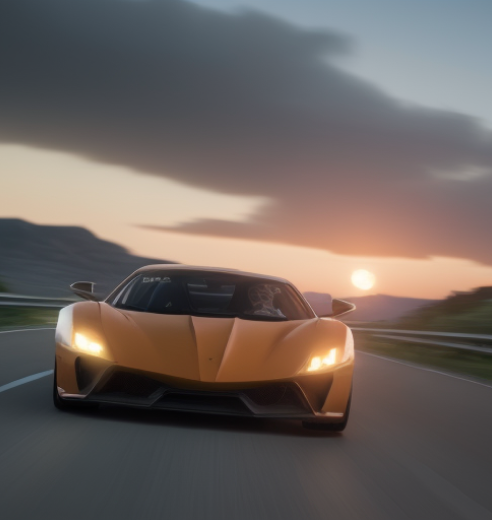

In [40]:
# Load image of a supercar
image = Image.open(car_path).convert("RGB")
image

In [41]:
image.size

(492, 520)

In [42]:
# Preprocess the image
inputs = blip_processor(image, return_tensors="pt").to(device, torch.float16)
inputs["pixel_values"].shape

torch.Size([1, 3, 224, 224])

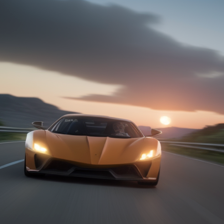

In [43]:
from sklearn.preprocessing import MinMaxScaler

# Convert to numpy and go from (1, 3, 224, 224) to (224, 224, 3) in shape
image_inputs = inputs["pixel_values"][0].detach().cpu().numpy()
image_inputs = np.einsum('ijk->kji', image_inputs)
image_inputs = np.einsum('ijk->jik', image_inputs)

# Scale image inputs to 0-255 to represent RGB values
scaler = MinMaxScaler(feature_range=(0, 255))
image_inputs = scaler.fit_transform(image_inputs.reshape(-1, image_inputs.shape[-1])).reshape(image_inputs.shape)
image_inputs = np.array(image_inputs, dtype=np.uint8)

# Convert numpy array to Image
Image.fromarray(image_inputs)

### Preprocessing Text

In [44]:
blip_processor.tokenizer

GPT2TokenizerFast(name_or_path='Salesforce/blip2-opt-2.7b', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50265: AddedToken("<image>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [45]:
# Preprocess the text
text = "Thanks for joining this session"
token_ids = blip_processor(text, text=text, return_tensors="pt")
token_ids = token_ids.to(device, torch.float16)["input_ids"][0]

# Convert input ids back to tokens
tokens = blip_processor.tokenizer.convert_ids_to_tokens(token_ids)
tokens

Expanding inputs for image tokens in BLIP-2 should be done in processing. Please follow instruction here (https://gist.github.com/zucchini-nlp/e9f20b054fa322f84ac9311d9ab67042) to update your BLIP-2 model. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.


['</s>', 'Thanks', 'Ġfor', 'Ġjoining', 'Ġthis', 'Ġsession']

In [46]:
# Replace the space token with an underscore
tokens = [token.replace("Ġ", "_") for token in tokens]
tokens

['</s>', 'Thanks', '_for', '_joining', '_this', '_session']

### Use Case 1: Image Captioning

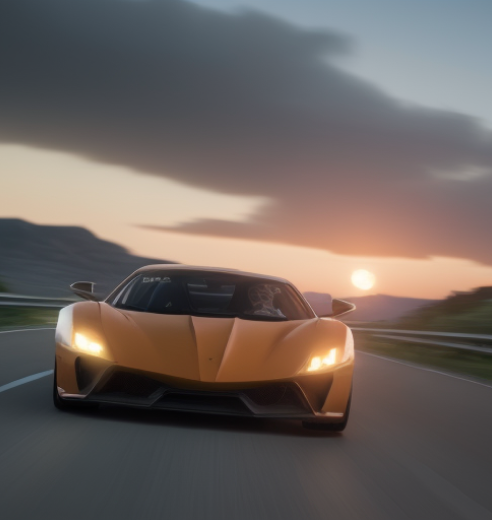

In [48]:
# Load an AI-generated image of a supercar
image = Image.open(car_path).convert("RGB")

# Convert an image into inputs and preprocess it
inputs = blip_processor(image, return_tensors="pt").to(device, torch.float16)
image

In [47]:
inputs['pixel_values'].shape

torch.Size([1, 3, 224, 224])

In [49]:
# Generate image ids to be passed to the decoder (LLM)
generated_ids = model.generate(**inputs, max_new_tokens=20)

# Generate text from the image ids
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = generated_text[0].strip()
generated_text

Expanding inputs for image tokens in BLIP-2 should be done in processing. Please follow instruction here (https://gist.github.com/zucchini-nlp/e9f20b054fa322f84ac9311d9ab67042) to update your BLIP-2 model. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


'an orange supercar driving on the road at sunset'

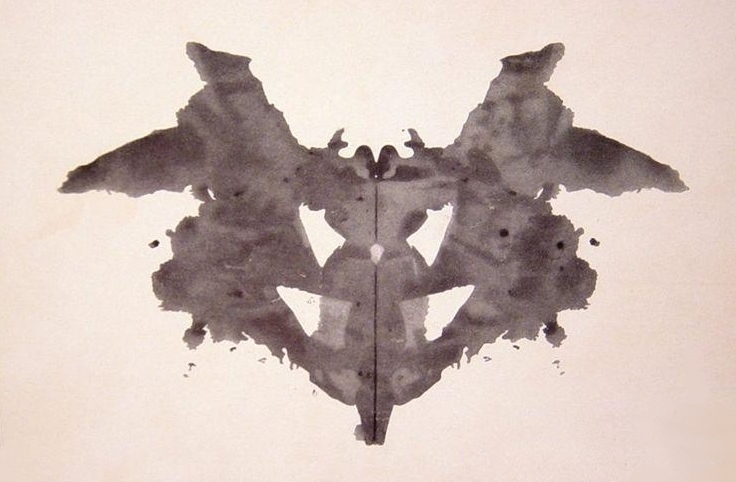

In [50]:
url = "https://upload.wikimedia.org/wikipedia/commons/7/70/Rorschach_blot_01.jpg"
image = Image.open(urlopen(url)).convert("RGB")
image

In [51]:
# Load rorschach image
url = "https://upload.wikimedia.org/wikipedia/commons/7/70/Rorschach_blot_01.jpg"
image = Image.open(urlopen(url)).convert("RGB")

# Generate caption
## Preprocessing the image
inputs = blip_processor(image, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = generated_text[0].strip()
generated_text

Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


'a black and white ink drawing of a bat'

### Use Case 2: Visual Question Answering

In [62]:
# Load an AI-generated image of a supercar
image = Image.open(car_path).convert("RGB")

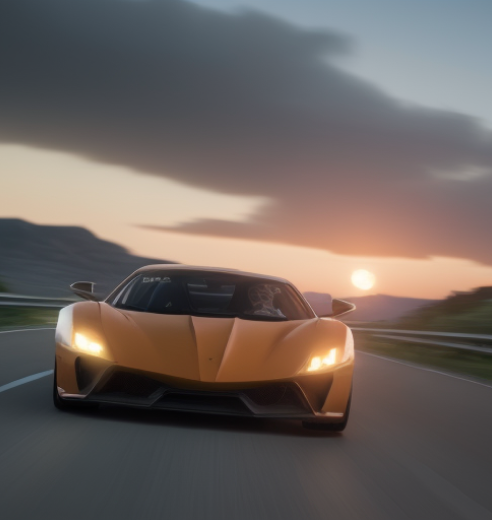

In [63]:
image

In [54]:
# Visual Question Answering
prompt = "Question: Write down what you see in this picture. Answer:"

# Process both the image and the prompt (image + text as an input)
inputs = blip_processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

# Generate text
generated_ids = model.generate(**inputs, max_new_tokens=30)
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = generated_text[0].strip()
generated_text

Both `max_new_tokens` (=30) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


'A sports car driving on the road at sunset'

In [55]:
# Chat-like prompting
prompt = "Question: Write down what you see in this picture. Answer: A sports car driving on the road at sunset. Question: What would it cost me to drive that car? Answer:"

# Generate output
inputs = blip_processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=30)
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = generated_text[0].strip()
generated_text

Both `max_new_tokens` (=30) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


'$1,000,000'

In [56]:
# Load an AI-generated image of a supercar
image = Image.open(car_path).convert("RGB")

In [57]:
from IPython.display import HTML, display
import ipywidgets as widgets

def text_eventhandler(*args):
  question = args[0]["new"]
  if question:
    args[0]["owner"].value = ""

    # Create prompt
    if not memory:
      prompt = " Question: " + question + " Answer:"
    else:
      template = "Question: {} Answer: {}."
      prompt = " ".join(
          [
              template.format(memory[i][0], memory[i][1])
              for i in range(len(memory))
          ]
      ) + " Question: " + question + " Answer:"

    # Generate text
    inputs = blip_processor(image, text=prompt, return_tensors="pt")
    inputs = inputs.to(device, torch.float16)
    generated_ids = model.generate(**inputs, max_new_tokens=100)
    generated_text = blip_processor.batch_decode(
        generated_ids,
        skip_special_tokens=True
    )
    generated_text = generated_text[0].strip().split("Question")[0]

    # Update memory
    memory.append((question, generated_text))

    # Assign to output
    output.append_display_data(HTML("<b>USER:</b> " + question))
    output.append_display_data(HTML("<b>BLIP-2:</b> " + generated_text))
    output.append_display_data(HTML("<br>"))

# Prepare widgets
in_text = widgets.Text()
in_text.continuous_update = False
in_text.observe(text_eventhandler, "value")
output = widgets.Output()
memory = []

# Display chat box
display(
    widgets.VBox(
        children=[output, in_text],
        layout=widgets.Layout(display="inline-flex", flex_flow="column-reverse"),
    )
)

Both `max_new_tokens` (=100) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=100) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=100) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
